这个笔记本使用原生 Python 绑定，为 MuJoCo 物理提供了一个入门教程
摘自：https://github.com/google-deepmind/mujoco/blob/main/python/tutorial.ipynb

# All imports

In [1]:
# !pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
    print('Checking that the installation succeeded:')
    import mujoco
    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


# Advanced rendering 高级渲染

In [2]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True


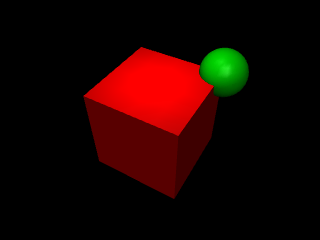

In [3]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

## Enable transparency and frame visualization 启用透明度和坐标可视化


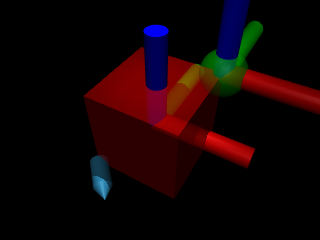

In [4]:
#@title Enable transparency and frame visualization {vertical-output: true}

scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data, scene_option=scene_option)
  frame = renderer.render()
  media.show_image(frame)

## Depth rendering 深度渲染


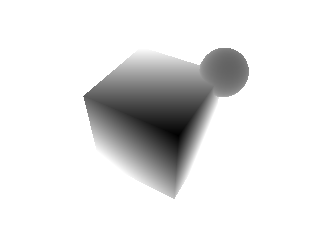

In [5]:
#@title Depth rendering {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  # update renderer to render depth
  renderer.enable_depth_rendering()

  # reset the scene
  renderer.update_scene(data)

  # depth is a float array, in meters.
  depth = renderer.render()

  # Shift nearest values to the origin.
  depth -= depth.min()
  # Scale by 2 mean distances of near rays.
  depth /= 2*depth[depth <= 1].mean()
  # Scale to [0, 255]
  pixels = 255*np.clip(depth, 0, 1)

  media.show_image(pixels.astype(np.uint8))

## Segmentation rendering 分割渲染


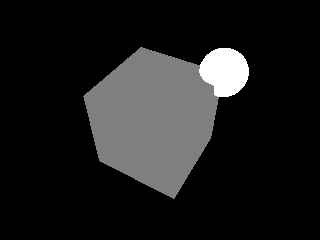

In [7]:
#@title Segmentation rendering {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  renderer.disable_depth_rendering()

  # update renderer to render segmentation
  renderer.enable_segmentation_rendering()

  # reset the scene
  renderer.update_scene(data)

  seg = renderer.render()

  # Display the contents of the first channel, which contains object
  # IDs. The second channel, seg[:, :, 1], contains object types.
  geom_ids = seg[:, :, 0]
  # Infinity is mapped to -1
  geom_ids = geom_ids.astype(np.float64) + 1
  # Scale to [0, 1]
  geom_ids = geom_ids / geom_ids.max()
  pixels = 255*geom_ids
  media.show_image(pixels.astype(np.uint8))

## The camera matrix 相机矩阵

In [8]:
def compute_camera_matrix(renderer, data):
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.vis.global_.fovy

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

### Project from world to camera coordinates 从世界坐标系到相机坐标的项目

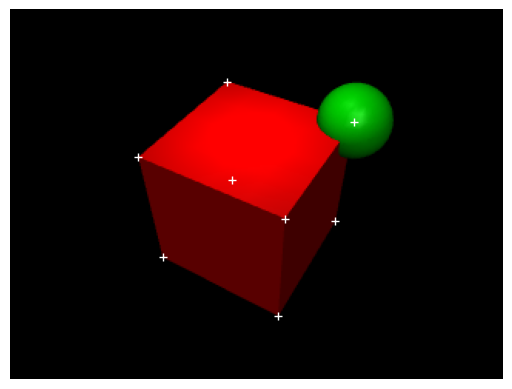

In [10]:
#@title Project from world to camera coordinates {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  renderer.disable_segmentation_rendering()
  # reset the scene
  renderer.update_scene(data)

  # Get the world coordinates of the box corners
  box_pos = data.geom_xpos[model.geom('red_box').id]
  box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
  box_size = model.geom_size[model.geom('red_box').id]
  offsets = np.array([-1, 1]) * box_size[:, None]
  xyz_local = np.stack(list(itertools.product(*offsets))).T
  xyz_global = box_pos[:, None] + box_mat @ xyz_local

  # Camera matrices multiply homogenous [x, y, z, 1] vectors.
  corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
  corners_homogeneous[:3, :] = xyz_global

  # Get the camera matrix.
  m = compute_camera_matrix(renderer, data)

  # Project world coordinates into pixel space. See:
  # https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
  xs, ys, s = m @ corners_homogeneous
  # x and y are in the pixel coordinate system.
  x = xs / s
  y = ys / s

  # Render the camera view and overlay the projected corner coordinates.
  pixels = renderer.render()
  fig, ax = plt.subplots(1, 1)
  ax.imshow(pixels)
  ax.plot(x, y, '+', c='w')
  ax.set_axis_off()

## Modifying the scene 修改场景

In [11]:
def get_geom_speed(model, data, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = data.geom(geom_name).id
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_connector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_connector(scene.geoms[scene.ngeom-1],
                       mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                       point1, point2)

 # traces of time, position and speed
times = []
positions = []
speeds = []
offset = model.jnt_axis[0]/16  # offset along the joint axis

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speeds[i])
      point1 = positions[i] + offset*times[i]
      point2 = positions[i+1] + offset*times[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    # append data to the traces
    positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())
    times.append(data.time)
    speeds.append(get_geom_speed(model, data, "green_sphere"))
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      modify_scene(renderer.scene)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

## Multiple frames in the same scene 同一场景中的多个坐标系

In [12]:
# Get MuJoCo's standard humanoid model.
print('Getting MuJoCo humanoid XML description from GitHub:')
!git clone https://github.com/google-deepmind/mujoco
with open('mujoco/model/humanoid/humanoid.xml', 'r') as f:
  xml = f.read()

# Load the model, make two MjData's.
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
data2 = mujoco.MjData(model)

# Episode parameters.
duration = 3       # (seconds)
framerate = 60     # (Hz)
data.qpos[0:2] = [-.5, -.5]  # Initial x-y position (m)
data.qvel[2] = 4   # Initial vertical velocity (m/s)
ctrl_phase = 2 * np.pi * np.random.rand(model.nu)  # Control phase
ctrl_freq = 1     # Control frequency

# Visual options for the "ghost" model.
vopt2 = mujoco.MjvOption()
vopt2.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True  # Transparent.
pert = mujoco.MjvPerturb()  # Empty MjvPerturb object
# We only want dynamic objects (the humanoid). Static objects (the floor)
# should not be re-drawn. The mjtCatBit flag lets us do that, though we could
# equivalently use mjtVisFlag.mjVIS_STATIC
catmask = mujoco.mjtCatBit.mjCAT_DYNAMIC

# Simulate and render.
frames = []
with mujoco.Renderer(model, 480, 640) as renderer:
  while data.time < duration:
    # Sinusoidal control signal.
    data.ctrl = np.sin(ctrl_phase + 2 * np.pi * data.time * ctrl_freq)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      # This draws the regular humanoid from `data`.
      renderer.update_scene(data)

      # Copy qpos to data2, move the humanoid sideways, call mj_forward.
      data2.qpos = data.qpos
      data2.qpos[0] += 1.5
      data2.qpos[1] += 1
      mujoco.mj_forward(model, data2)

      # Call mjv_addGeoms to add the ghost humanoid to the scene.
      mujoco.mjv_addGeoms(model, data2, vopt2, pert, catmask, renderer.scene)

      # Render and add the frame.
      pixels = renderer.render()
      frames.append(pixels)

# Render video at half real-time.
media.show_video(frames, fps=framerate/2)

Getting MuJoCo humanoid XML description from GitHub:
正克隆到 'mujoco'...
remote: Enumerating objects: 31745, done.
remote: Counting objects: 100% (1406/1406), done.
remote: Compressing objects: 100% (523/523), done.
remote: Total 31745 (delta 1064), reused 884 (delta 883), pack-reused 30339 (from 3)
接收对象中: 100% (31745/31745), 109.47 MiB | 14.89 MiB/s, 完成.
处理 delta 中: 100% (24521/24521), 完成.


## Camera control 相机控制

### Load the "dominos" model 加载骨牌模型

In [14]:
#@title Load the "dominos" model

dominos_xml = """
<mujoco>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true" reflectance=".2"/>
  </asset>

  <statistic meansize=".01"/>

  <visual>
    <global offheight="2160" offwidth="3840"/>
    <quality offsamples="8"/>
  </visual>

  <default>
    <geom type="box" solref=".005 1"/>
    <default class="static">
      <geom rgba=".3 .5 .7 1"/>
    </default>
  </default>

  <option timestep="5e-4"/>

  <worldbody>
    <light pos=".3 -.3 .8" mode="trackcom" diffuse="1 1 1" specular=".3 .3 .3"/>
    <light pos="0 -.3 .4" mode="targetbodycom" target="box" diffuse=".8 .8 .8" specular=".3 .3 .3"/>
    <geom name="floor" type="plane" size="3 3 .01" pos="-0.025 -0.295  0" material="grid"/>
    <geom name="ramp" pos=".25 -.45 -.03" size=".04 .1 .07" euler="-30 0 0" class="static"/>
    <camera name="top" pos="-0.37 -0.78 0.49" xyaxes="0.78 -0.63 0 0.27 0.33 0.9"/>

    <body name="ball" pos=".25 -.45 .1">
      <freejoint name="ball"/>
      <geom name="ball" type="sphere" size=".02" rgba=".65 .81 .55 1"/>
    </body>

    <body pos=".26 -.3 .03" euler="0 0 -90.0">
      <freejoint/>
      <geom size=".0015 .015 .03" rgba="1 .5 .5 1"/>
    </body>

    <body pos=".26 -.27 .04" euler="0 0 -81.0">
      <freejoint/>
      <geom size=".002 .02 .04" rgba="1 1 .5 1"/>
    </body>

    <body pos=".24 -.21 .06" euler="0 0 -63.0">
      <freejoint/>
      <geom size=".003 .03 .06" rgba=".5 1 .5 1"/>
    </body>

    <body pos=".2 -.16 .08" euler="0 0 -45.0">
      <freejoint/>
      <geom size=".004 .04 .08" rgba=".5 1 1 1"/>
    </body>

    <body pos=".15 -.12 .1" euler="0 0 -27.0">
      <freejoint/>
      <geom size=".005 .05 .1" rgba=".5 .5 1 1"/>
    </body>

    <body pos=".09 -.1 .12" euler="0 0 -9.0">
      <freejoint/>
      <geom size=".006 .06 .12" rgba="1 .5 1 1"/>
    </body>

    <body name="seasaw_wrapper" pos="-.23 -.1 0" euler="0 0 30">
      <geom size=".01 .01 .015" pos="0 .05 .015" class="static"/>
      <geom size=".01 .01 .015" pos="0 -.05 .015" class="static"/>
      <geom type="cylinder" size=".01 .0175" pos="-.09 0 .0175" class="static"/>
      <body name="seasaw" pos="0 0 .03">
        <joint axis="0 1 0"/>
        <geom type="cylinder" size=".005 .039" zaxis="0 1 0" rgba=".84 .15 .33 1"/>
        <geom size=".1 .02 .005" pos="0 0 .01" rgba=".84 .15 .33 1"/>
      </body>
    </body>

    <body name="box" pos="-.3 -.14 .05501" euler="0 0 -30">
      <freejoint name="box"/>
      <geom name="box" size=".01 .01 .01" rgba=".0 .7 .79 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(dominos_xml)
data = mujoco.MjData(model)


### Render from fixed camera 从固定相机渲染

In [16]:
#@title Render from fixed camera

duration = 2.5  # (seconds)
framerate = 60  # (Hz)
height = 1024
width = 1440

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
with mujoco.Renderer(model, height, width) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, camera='top')
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

### Render from moving camera 从移动相机渲染

In [18]:
#@title Render from moving camera

duration = 3  # (seconds)
height = 1024
width = 1440

# find time when box is thrown (speed > 2cm/s)
throw_time = 0.0
mujoco.mj_resetData(model, data)
while data.time < duration and not throw_time:
  mujoco.mj_step(model, data)
  box_speed = np.linalg.norm(data.joint('box').qvel[:3])
  if box_speed > 0.02:
    throw_time = data.time
assert throw_time > 0

def mix(time, t0=0.0, width=1.0):
  """Sigmoidal mixing function."""
  t = (time - t0) / width
  s = 1 / (1 + np.exp(-t))
  return 1 - s, s

def unit_cos(t):
  """Unit cosine sigmoid from (0,0) to (1,1)."""
  return 0.5 - np.cos(np.pi*np.clip(t, 0, 1))/2

def orbit_motion(t):
  """Return orbit trajectory."""
  distance = 0.9
  azimuth = 140 + 100 * unit_cos(t)
  elevation = -30
  lookat = data.geom('floor').xpos.copy()
  return distance, azimuth, elevation, lookat

def track_motion():
  """Return box-track trajectory."""
  distance = 0.08
  azimuth = 280
  elevation = -10
  lookat = data.geom('box').xpos.copy()
  return distance, azimuth, elevation, lookat

def cam_motion():
  """Return sigmoidally-mixed {orbit, box-track} trajectory."""
  d0, a0, e0, l0 = orbit_motion(data.time / throw_time)
  d1, a1, e1, l1 = track_motion()
  mix_time = 0.3
  w0, w1 = mix(data.time, throw_time, mix_time)
  return w0*d0+w1*d1, w0*a0+w1*a1, w0*e0+w1*e1, w0*l0+w1*l1

# Make a camera.
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)

# Simulate and display video.
framerate = 60  # (Hz)
slowdown = 4    # 4x slow-down
mujoco.mj_resetData(model, data)
frames = []
with mujoco.Renderer(model, height, width) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate * slowdown:
      cam.distance, cam.azimuth, cam.elevation, cam.lookat = cam_motion()
      renderer.update_scene(data, cam)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)